In [226]:
from netCDF4 import Dataset, stringtochar, num2date, date2num, chartostring
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from datetime import datetime, timedelta
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import copy
from numpy import ma
import math
from scipy import stats
import properscoring as ps
import pandas as pd


input_path_QRF_fcsts = '/volumes/DataCaddy/Joseph_stuff/Project_Renewable_energy/QRF_fcsts/windSpeed/'
output_path_figures = '/users/jbellier/Documents/Project_Renewable_energy/QRF/Figures/'

month = 1
leads = np.arange(3,186+1,3)

bounds_area = [39, 41, -106, -104]
avail_years = range(2000,2020)

name_pred = ['mean','ctrl','median','std','MD','Q10','Q90','msl_pres']

## Compute verification metrics

In [227]:
nday = [31,29,31,30,31,30,31,31,30,31,30,31][month-1]   # number of days for the month selected. The code might need to be adapted for February...
name_month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][month-1]
nyear = len(avail_years)
npred = len(name_pred)

## Functions that compute the CRPS and the rank of the obs within the ensemble (for plotting rank histograms),
##   and then mask the elements where either the obs is missing, or one of the ensemble member is missing:
def compute_crps(obs, fcst):
    crps = ma.array(ps.crps_ensemble(obs, fcst, axis=-1), 
                    mask=np.logical_or(obs.mask, np.any(fcst.mask, axis=-1)))
    return crps

def get_rankobs(obs, fcst):
    fcst_and_obs = np.concatenate((fcst, obs[...,None]), axis=-1)
    rankobs = ma.array(np.argmax(np.argsort(fcst_and_obs + np.random.random_sample(fcst_and_obs.shape)*1e-04, axis=-1), axis=-1), 
                       mask=np.logical_or(obs.mask, np.any(fcst.mask, axis=-1)))
    return rankobs

In [228]:
nlead = len(leads)
for l in range(nlead):
    lead = leads[l]
    print('Computing verification metrics for lead '+str(lead)+'h...')

    ncfile = input_path_QRF_fcsts + 'test_QRF_fcst_windSpeed_month_'+str(month)+'_lead_'+str(lead)+'h.nc'
    nc = Dataset(ncfile)
    
    if l==0:
        lons = nc.variables['lon'][:]
        lats = nc.variables['lat'][:]
        yyyymmddhh_init = nc.variables['yyyymmddhh_init'][:]
        ntime, ny, nx = yyyymmddhh_init.size, lats.size, lons.size
        
        crps_GEFS = ma.array(np.zeros((nlead,ntime,ny,nx)), mask=True)
        crps_QRF = ma.array(np.zeros((nlead,ntime,ny,nx)), mask=True)
        crps_QRF_5memb = ma.array(np.zeros((nlead,ntime,ny,nx)), mask=True)
        crps_clim = ma.array(np.zeros((nlead,ntime,ny,nx)), mask=True)
        
        rankObs_GEFS = ma.array(np.zeros((nlead,ntime,ny,nx)), mask=True)
        rankObs_QRF = ma.array(np.zeros((nlead,ntime,ny,nx)), mask=True)
        rankObs_QRF_5memb = ma.array(np.zeros((nlead,ntime,ny,nx)), mask=True)
        rankObs_clim = ma.array(np.zeros((nlead,ntime,ny,nx)), mask=True)
        
    crps_GEFS[l,:,:,:] = compute_crps(nc.variables['obs_ERA5'][:], nc.variables['fcst_GEFS'][:])
    crps_QRF[l,:,:,:] = compute_crps(nc.variables['obs_ERA5'][:], nc.variables['fcst_QRF'][:])
    crps_QRF_5memb[l,:,:,:] = compute_crps(nc.variables['obs_ERA5'][:], nc.variables['fcst_QRF_5memb'][:])
    crps_clim[l,:,:,:] = compute_crps(nc.variables['obs_ERA5'][:], nc.variables['fcst_clim'][:])
    
    rankObs_GEFS[l,:,:,:] = get_rankobs(nc.variables['obs_ERA5'][:], nc.variables['fcst_GEFS'][:])
    rankObs_QRF[l,:,:,:] = get_rankobs(nc.variables['obs_ERA5'][:], nc.variables['fcst_QRF'][:])
    rankObs_QRF_5memb[l,:,:,:] = get_rankobs(nc.variables['obs_ERA5'][:], nc.variables['fcst_QRF_5memb'][:])
    rankObs_clim[l,:,:,:] = get_rankobs(nc.variables['obs_ERA5'][:], nc.variables['fcst_clim'][:])

    nc.close()

Computing verification metrics for lead 3h...
Computing verification metrics for lead 6h...
Computing verification metrics for lead 9h...
Computing verification metrics for lead 12h...
Computing verification metrics for lead 15h...
Computing verification metrics for lead 18h...
Computing verification metrics for lead 21h...
Computing verification metrics for lead 24h...
Computing verification metrics for lead 27h...
Computing verification metrics for lead 30h...
Computing verification metrics for lead 33h...
Computing verification metrics for lead 36h...
Computing verification metrics for lead 39h...
Computing verification metrics for lead 42h...
Computing verification metrics for lead 45h...
Computing verification metrics for lead 48h...
Computing verification metrics for lead 51h...
Computing verification metrics for lead 54h...
Computing verification metrics for lead 57h...
Computing verification metrics for lead 60h...
Computing verification metrics for lead 63h...
Computing verifi

## Verification plots

#### Plot CRPSS (averaged over all pixels) over lead times :

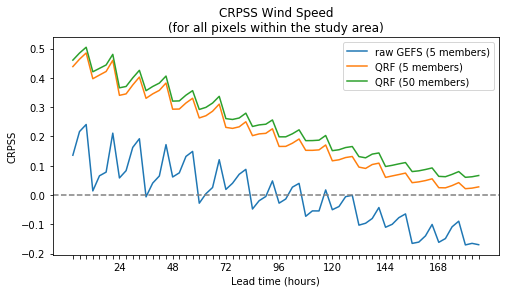

In [231]:
crps_meanArea_clim = np.mean(crps_clim, axis=(1,2,3))
crpss_meanArea_GEFS = 1 - np.mean(crps_GEFS, axis=(1,2,3))/crps_meanArea_clim
crpss_meanArea_QRF = 1 - np.mean(crps_QRF, axis=(1,2,3))/crps_meanArea_clim
crpss_meanArea_QRF_5memb = 1 - np.mean(crps_QRF_5memb, axis=(1,2,3))/crps_meanArea_clim

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(leads, crpss_meanArea_GEFS, label='raw GEFS (5 members)')
ax.plot(leads, crpss_meanArea_QRF_5memb, label='QRF (5 members)')
ax.plot(leads, crpss_meanArea_QRF, label='QRF (50 members)')
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend()
plt.xticks(leads)
[label.set_visible(False) for (l,label) in enumerate(ax.xaxis.get_ticklabels()) if leads[l] % 24 != 0]
plt.ylabel('CRPSS')
plt.xlabel('Lead time (hours)')
plt.title('CRPSS Wind Speed\n(for all pixels within the study area)')
plt.savefig(output_path_figures+'CRPSS_allPixels.pdf')
plt.show()

#### Plot CRPSS (one pixel) over lead times :

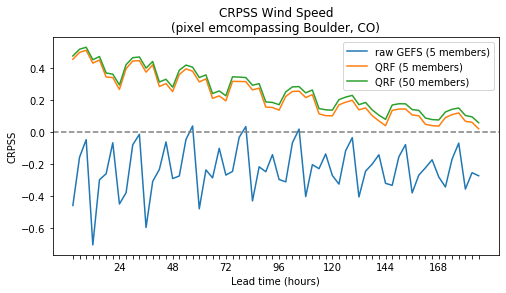

In [232]:
j,i = np.argmin(np.abs(lats - 40.0150)), np.argmin(np.abs(lons - (-105.2705)))

crps_meanArea_clim = np.mean(crps_clim[:,:,j,i], axis=1)
crpss_meanArea_GEFS = 1 - np.mean(crps_GEFS[:,:,j,i], axis=1)/crps_meanArea_clim
crpss_meanArea_QRF = 1 - np.mean(crps_QRF[:,:,j,i], axis=1)/crps_meanArea_clim
crpss_meanArea_QRF_5memb = 1 - np.mean(crps_QRF_5memb[:,:,j,i], axis=1)/crps_meanArea_clim

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(leads, crpss_meanArea_GEFS, label='raw GEFS (5 members)')
ax.plot(leads, crpss_meanArea_QRF_5memb, label='QRF (5 members)')
ax.plot(leads, crpss_meanArea_QRF, label='QRF (50 members)')
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend()
plt.xticks(leads)
[label.set_visible(False) for (l,label) in enumerate(ax.xaxis.get_ticklabels()) if leads[l] % 24 != 0]
plt.ylabel('CRPSS')
plt.xlabel('Lead time (hours)')
plt.title('CRPSS Wind Speed\n(pixel emcompassing Boulder, CO)')
plt.savefig(output_path_figures+'CRPSS_Boulder.pdf')
plt.show()

#### Map CRPSS for individual lead times:

In [217]:
res = 0.25
## For pcolormesh:
lons_pmesh = np.append(lons - res/2, lons[-1] + res/2)
lats_pmesh = np.append(lats - res/2, lats[-1] + res/2)

img_extent = [bounds_area[2]-res, bounds_area[3]+res, bounds_area[0]-res, bounds_area[1]+res]

## To plot in Cartopy the ticks every x lat/lon degres:
def get_xticks(x_extent, inc = 1):
    x_inc = np.arange(-180,180,inc)
    return(x_inc[np.where(np.logical_and(x_inc >= x_extent[0], x_inc <= x_extent[1]))])

def get_yticks(y_extent, inc = 1):
    y_inc = np.arange(-90,90,inc)
    return(y_inc[np.where(np.logical_and(y_inc >= y_extent[0], y_inc <= y_extent[1]))])

## To adjust the center of the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.array(np.interp(value, x, y), mask=result.mask, copy=False)


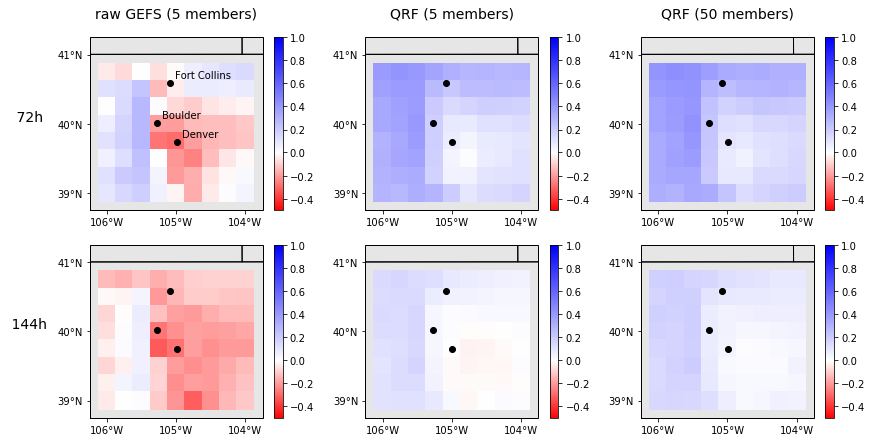

In [233]:
leads_plt = [72,144]
fcst_plt = ['raw GEFS (5 members)','QRF (5 members)','QRF (50 members)']
nlead_plt, nfcst_plt = len(leads_plt), len(fcst_plt)

cities = [['Boulder',(-105.2705,40.0150)], ['Denver',(-104.9903,39.7392)],['Fort Collins',(-105.0844,40.5853)]]
ncity = len(cities)

norm = MidpointNormalize(midpoint=0, vmin=-0.5, vmax=1)

fig = plt.figure(figsize=(14,7))
p = 1
for k in range(nlead_plt):
    l = np.where(leads==leads_plt[k])[0][0]
    crps_map_clim = np.mean(crps_clim[l,:,:,:], axis=0)
    for f in range(nfcst_plt):
        ax = fig.add_subplot(nlead_plt,nfcst_plt,p, projection=ccrs.PlateCarree())
        ax.imshow(np.tile(np.array([[[230,230,230]]], dtype=np.uint8), [2, 2, 1]), transform=ccrs.PlateCarree(), extent=[-180, 180, -180, 180])
        if f==0:
            crpss_map = 1 - np.mean(crps_GEFS[l,:,:,:], axis=0)/crps_map_clim
        elif f==1:
            crpss_map = 1 - np.mean(crps_QRF_5memb[l,:,:,:], axis=0)/crps_map_clim
        elif f==2:
            crpss_map = 1 - np.mean(crps_QRF[l,:,:,:], axis=0)/crps_map_clim
        cmesh = ax.pcolormesh(lons_pmesh, lats_pmesh, crpss_map, cmap='bwr_r', norm=norm)
        ax.set_extent(img_extent, crs=ccrs.PlateCarree())
        ax.set_yticks(get_yticks(img_extent[2:4],1), crs=ccrs.PlateCarree())
        ax.yaxis.set_major_formatter(LatitudeFormatter()) 
        ax.set_xticks(get_xticks(img_extent[0:2],1), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        ax.add_feature(cfeature.STATES)
        ax.scatter(x=[cities[c][1][0] for c in range(ncity)], y = [cities[c][1][1] for c in range(ncity)], color='black')
        cbar = plt.colorbar(cmesh)
        if k==0: ax.set_title(fcst_plt[f], fontsize=14, pad=20)
        if f==0: plt.ylabel(' '+str(leads_plt[k])+'h', fontsize = 14, rotation=0, labelpad=30)
        if k==0 and f==0: [ax.annotate(*city, xytext=(5,5), textcoords='offset points') for city in cities]
        p = p+1

# fig.canvas.draw()
# plt.tight_layout(rect=[0,0,1,0.80])
plt.savefig(output_path_figures+'map_CRPSS.pdf')
plt.show()

#### Rank histograms (averaged over all pixels)

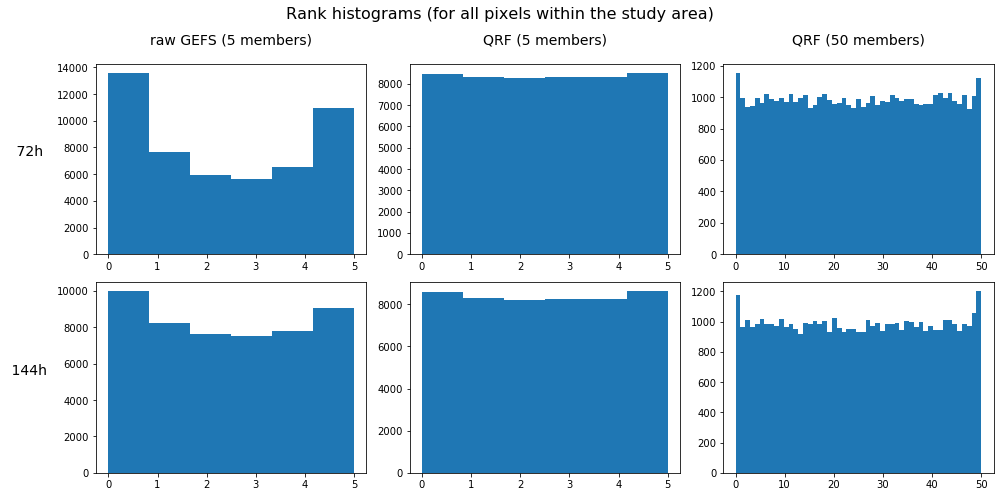

In [234]:
leads_plt = [72,144]
fcst_plt = ['raw GEFS (5 members)','QRF (5 members)','QRF (50 members)']
nlead_plt, nfcst_plt = len(leads_plt), len(fcst_plt)

fig = plt.figure(figsize=(14,7))
p = 1
for k in range(nlead_plt):
    l = np.where(leads==leads_plt[k])[0][0]
    for f in range(nfcst_plt):
        ax = fig.add_subplot(nlead_plt,nfcst_plt,p)
        if f==0:
            rankObs = rankObs_GEFS[l,:,:,:].ravel()
        elif f==1:
            rankObs = rankObs_QRF_5memb[l,:,:,:].ravel()
        elif f==2:
            rankObs = rankObs_QRF[l,:,:,:].ravel()
        plt.hist(rankObs[rankObs.mask==False], bins=int(np.max(rankObs))+1)
        if k==0: ax.set_title(fcst_plt[f], fontsize=14, pad=20)
        if f==0: plt.ylabel(' '+str(leads_plt[k])+'h', fontsize = 14, rotation=0, labelpad=30)
        p = p+1
        
fig.suptitle('Rank histograms (for all pixels within the study area)', fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig(output_path_figures+'RH_allPixs.pdf')
plt.show()

#### Rank histograms (one pixel)

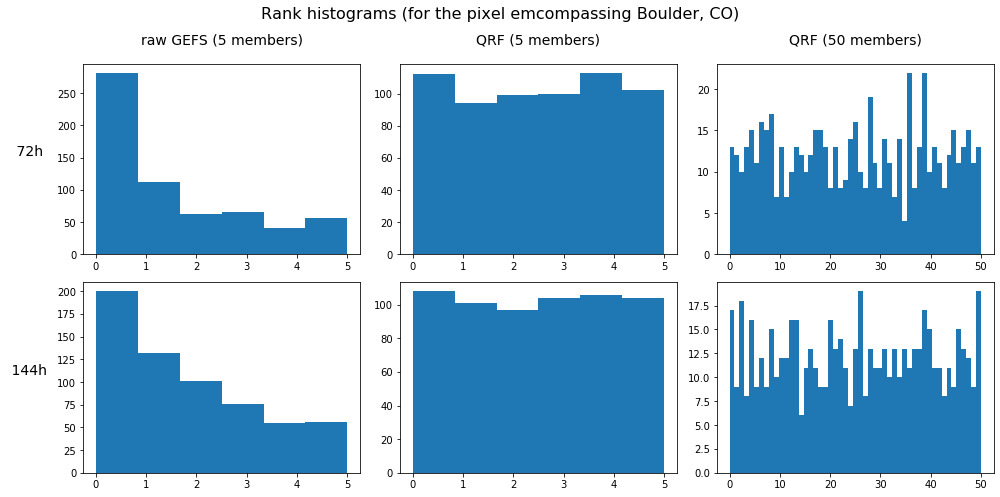

In [235]:
j,i = np.argmin(np.abs(lats - 40.0150)), np.argmin(np.abs(lons - (-105.2705)))

leads_plt = [72,144]
fcst_plt = ['raw GEFS (5 members)','QRF (5 members)','QRF (50 members)']
nlead_plt, nfcst_plt = len(leads_plt), len(fcst_plt)

fig = plt.figure(figsize=(14,7))
p = 1
for k in range(nlead_plt):
    l = np.where(leads==leads_plt[k])[0][0]
    for f in range(nfcst_plt):
        ax = fig.add_subplot(nlead_plt,nfcst_plt,p)
        if f==0:
            rankObs = rankObs_GEFS[l,:,j,i]
        elif f==1:
            rankObs = rankObs_QRF_5memb[l,:,j,i]
        elif f==2:
            rankObs = rankObs_QRF[l,:,j,i]
        plt.hist(rankObs[rankObs.mask==False], bins=int(np.max(rankObs))+1)
        if k==0: ax.set_title(fcst_plt[f], fontsize=14, pad=20)
        if f==0: plt.ylabel(' '+str(leads_plt[k])+'h', fontsize = 14, rotation=0, labelpad=30)
        p = p+1

fig.suptitle('Rank histograms (for the pixel emcompassing Boulder, CO)', fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig(output_path_figures+'RH_Boulder.pdf')
plt.show()

## Statistics of the QRF fits:

In [236]:
pred_importance = ma.array(np.zeros((nlead,nyear,ny,nx,npred)))

for l in range(nlead):
    lead = leads[l]
    npzfile = np.load(input_path_QRF_fcsts+'test_QRF_predictorImportance_windSpeed_month_'+str(month)+'_lead_'+str(lead)+'h.npz')
    pred_importance[l,:,:,:,:] = ma.array(npzfile['pred_importance'], mask=npzfile['pred_importance'] == -999)

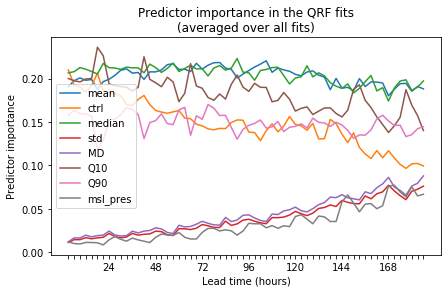

In [237]:
fig, ax = plt.subplots(figsize=(7,4))
for p in range(npred):
    ax.plot(leads, np.mean(pred_importance[:,:,:,:,p], axis=(1,2,3)), label=name_pred[p])
plt.legend(ncol=1)
plt.ylabel('Predictor importance')
plt.xticks(leads)
[label.set_visible(False) for (l,label) in enumerate(ax.xaxis.get_ticklabels()) if leads[l] % 24 != 0]
plt.title('Predictor importance in the QRF fits\n(averaged over all fits)')
plt.xlabel('Lead time (hours)')
plt.savefig(output_path_figures+'Predictor_importance.pdf')
plt.show()